In [1]:
import plotly.graph_objects as go
import networkx as nx
import os

# reading input log file

test_name = "ddmd"

stat_path=f"example_stat/{test_name}"
image_path=f"{stat_path}/images"



In [2]:
# My utility functions
import utils.stat_loader as sload
import utils.stat_print as sp
import utils.vfd_stat2graph as vfd2g
import utils.vfd_graph2sankey as vfd2sk
import utils.full_stat2graph as f2g

# Improve Functions
## TODO
- Add dataset nodes
- Add file address ordering nodes


In [3]:
STAGE_START = 0
STAGE_END = 1


TASK_ORDER_LIST = sload.load_task_order_list(stat_path)
STAGE_END = sload.correct_end_stage(TASK_ORDER_LIST, STAGE_END)

TASK_ORDER_LIST = sload.current_task_order_list(TASK_ORDER_LIST, STAGE_START, STAGE_END)

TASK_LISTS = list(TASK_ORDER_LIST.keys())

print(f"TASK_ORDER_LIST = {TASK_ORDER_LIST}")
TASK_LISTS


TASK_ORDER_LIST = {'openmm': 0, 'aggregate': 1}


['openmm', 'aggregate']

In [4]:
vfd_files = sload.find_files_with_pattern(stat_path, "vfd")
# vfd_files = vfd_files[0:1]
print(f"vfd_files: {vfd_files}")

vfd_dict = sload.load_stat_json(vfd_files)
# print(vfd_dict)


# vol_files = sload.find_files_with_pattern(stat_path, "vol")
# # vol_files = vol_files[0:1]
# print(f"vol_files: {vol_files}")

# vol_dict = sload.load_stat_json(vol_files)

print("loading json done")

vfd_files: ['example_stat/ddmd/378094-vfd_data_stat.json', 'example_stat/ddmd/378096-vfd_data_stat.json', 'example_stat/ddmd/378097-vfd_data_stat.json', 'example_stat/ddmd/378100-vfd_data_stat.json', 'example_stat/ddmd/378102-vfd_data_stat.json', 'example_stat/ddmd/378105-vfd_data_stat.json', 'example_stat/ddmd/378110-vfd_data_stat.json', 'example_stat/ddmd/378115-vfd_data_stat.json', 'example_stat/ddmd/378116-vfd_data_stat.json', 'example_stat/ddmd/378119-vfd_data_stat.json', 'example_stat/ddmd/378120-vfd_data_stat.json', 'example_stat/ddmd/378126-vfd_data_stat.json', 'example_stat/ddmd/379606-vfd_data_stat.json', 'example_stat/ddmd/379664-vfd_data_stat.json', 'example_stat/ddmd/379835-vfd_data_stat.json']
loading example_stat/ddmd/378094-vfd_data_stat.json
loading example_stat/ddmd/378096-vfd_data_stat.json
loading example_stat/ddmd/378097-vfd_data_stat.json
loading example_stat/ddmd/378100-vfd_data_stat.json
loading example_stat/ddmd/378102-vfd_data_stat.json
loading example_stat/dd

In [5]:
# Show VFD Tracker overhead
sp.show_all_overhead("VFD", vfd_dict)

Total VFD overhead: 3161455.5750000007 ms
Total POSIX IO time: 304234.6429999999 us
Total POSIX OPEN time: 29410.593999999994 us
Total POSIX CLOSE time: 10868.365000000002 us
Total POSIX READ time: 221179.11099999986 us
Total POSIX WRITE time: 42776.57300000005 us
Total POSIX DELETE time: 0.0 us


In [6]:
def inc_in_dict(dic, k):
    if k not in dic:
        dic[k] = 0
    else:
        dic[k]+=1



G_VFD = nx.DiGraph()
G_VFD = f2g.add_task_dset_file_nodes(G_VFD, vfd_dict, TASK_ORDER_LIST)

# sp.display_all_edges_attr(G_VFD)
# sp.display_all_nodes_position(G_VFD)

In [7]:


file_page_nodes_attr, dset_page_edges = f2g.get_file_dset_maps(vfd_dict, TASK_ORDER_LIST)

# for k,v in file_page_nodes_attr.items():
#     print(f"file_page_nodes_attr: {k} -> {v}")

add_edge_stat,edges_to_remove,nodes_to_add = f2g.add_file_page(G_VFD, file_page_nodes_attr, dset_page_edges)

# for k,v in add_edge_stat.items():
#     print(f"add_edge_stat: {k} -> {v}")

# for k in nodes_to_add.keys():
#     stat = nodes_to_add[k]
#     print(f"nodes_to_add: {k} -> {stat[k]['pos']}")

# print(f"edges_to_remove: {edges_to_remove}")


file_page_nodes_attr: {'[0-5)': {'pos': (0, 0), 'rpos': 0, 'range': (0, 5), 'size': 327680}, '[5-10)': {'pos': (0, 1), 'rpos': 0, 'range': (5, 10), 'size': 327680}, '[10-15)': {'pos': (0, 2), 'rpos': 0, 'range': (10, 15), 'size': 327680}, '[15-20)': {'pos': (0, 3), 'rpos': 0, 'range': (15, 20), 'size': 327680}}
dset_page_edges: {('contact_map-0-W', '[0-5)'): {'access_cnt': 2400, 'access_type': 'write'}, ('file-0-W', '[0-5)'): {'access_cnt': 192, 'access_type': 'write'}, ('fnc-0-W', '[0-5)'): {'access_cnt': 2400, 'access_type': 'write'}, ('point_cloud-0-W', '[0-5)'): {'access_cnt': 1462, 'access_type': 'write'}, ('rmsd-0-W', '[0-5)'): {'access_cnt': 2400, 'access_type': 'write'}, ('[0-5)', 'contact_map-1-R'): {'access_cnt': 72, 'access_type': 'read'}, ('contact_map-1-W', '[5-10)'): {'access_cnt': 98, 'access_type': 'write'}, ('contact_map-1-W', '[10-15)'): {'access_cnt': 140, 'access_type': 'write'}, ('contact_map-1-W', '[15-20)'): {'access_cnt': 128, 'access_type': 'write'}, ('[0-5)', 

In [8]:
def update_nodes_edges(G,add_edge_stat, edges_to_remove, nodes_to_add):
    G.remove_edges_from(edges_to_remove)
    
    G.add_edges_from(add_edge_stat.keys())
    nx.set_edge_attributes(G, add_edge_stat)
    
    for page_nodes in nodes_to_add:
        G.add_node(page_nodes, pos=nodes_to_add[page_nodes][page_nodes]['pos'])
        page_node_attrs = {page_nodes: {'rpos':nodes_to_add[page_nodes][page_nodes]['rpos'], 'phase': nodes_to_add[page_nodes][page_nodes]['phase'], 'type':nodes_to_add[page_nodes][page_nodes]['type'], 'size': nodes_to_add[page_nodes][page_nodes]['size'], 'range': nodes_to_add[page_nodes][page_nodes]['range']}}
        nx.set_node_attributes(G, page_node_attrs)
        # print added new node
        print(f"add new node: {page_nodes} -> {G.nodes[page_nodes]}")
    return G


G_VFD = update_nodes_edges(G_VFD,add_edge_stat, edges_to_remove, nodes_to_add)

add new node: [0-5)-0-R -> {'pos': (4, 0), 'rpos': 1, 'phase': 0, 'type': 'addr', 'size': 327680, 'range': (0, 5)}
add new node: [0-5)-0-W -> {'pos': (2, 1), 'rpos': 1, 'phase': 0, 'type': 'addr', 'size': 327680, 'range': (0, 5)}
add new node: [5-10)-1-W -> {'pos': (8, 0), 'rpos': 1, 'phase': 1, 'type': 'addr', 'size': 327680, 'range': (5, 10)}
add new node: [10-15)-1-W -> {'pos': (8, 1), 'rpos': 1, 'phase': 1, 'type': 'addr', 'size': 327680, 'range': (10, 15)}
add new node: [15-20)-1-W -> {'pos': (8, 2), 'rpos': 1, 'phase': 1, 'type': 'addr', 'size': 327680, 'range': (15, 20)}
add new node: [0-5)-1-W -> {'pos': (8, 3), 'rpos': 1, 'phase': 1, 'type': 'addr', 'size': 327680, 'range': (0, 5)}


edge_types: {'page-file', 'dset-page', 'file-page', 'page-dset', 'dset-task', 'task-dset'}


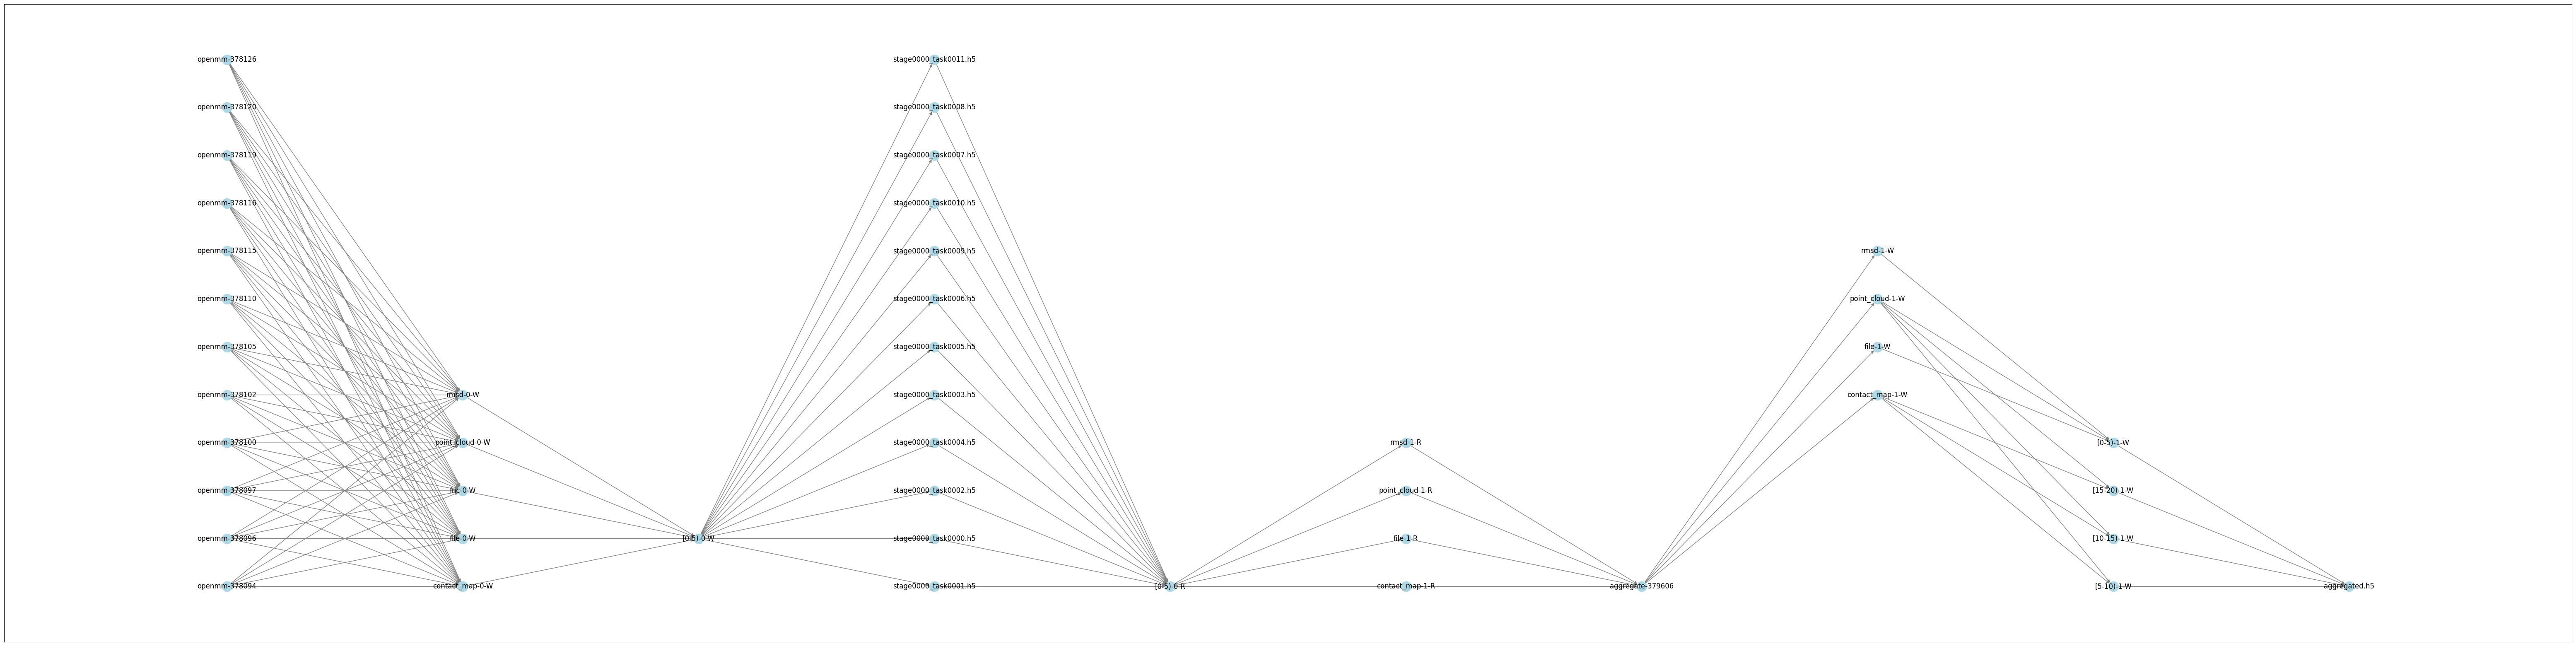

In [9]:
# G_VFD = vfd2g.set_task_position_full(G_VFD, task_file_map, STAGE_START)
# sp.display_all_nodes_attr(G_VFD)
all_edge_types = nx.get_edge_attributes(G_VFD,'edge_type')
edge_types = []
for edge in all_edge_types:
    edge_types.append(all_edge_types[edge])

print(f"edge_types: {set(edge_types)}")

sp.draw_graph(G_VFD, test_name, stat_path, graph_type="vfd", prefix=f'{(STAGE_END+1)}s', save=True)

In [10]:
# sp.display_all_edges_attr(G_VFD)
# sp.display_all_nodes_position(G_VFD)

# Add networkx to Sankey diagram

## Statistics for Sankey
Below are needed edge attributes before generating the sankey diagram:
- access_cnt : The total file/dataset access count 
- access_size : The total read and write access size
- operation : The operation type : read, write, read_write
- bandwidth : Get the per access size and time, then calculate the bandwidth. Average the bandwidth if multiple accesses. (TODO: currently only recording one access size and time)




In [11]:
f2g.prepare_sankey_stat_full(G_VFD)
vfd2sk.time_to_file_x_pos(G_VFD)

All tasks:  ['openmm-378094', 'openmm-378096', 'openmm-378097', 'openmm-378100', 'openmm-378102', 'openmm-378105', 'openmm-378110', 'openmm-378115', 'openmm-378116', 'openmm-378119', 'openmm-378120', 'openmm-378126', 'aggregate-379606']
contact_map-1-R New pos:  (5.25, 0)
file-1-R New pos:  (5.25, 1)
point_cloud-1-R New pos:  (5.25, 2)
rmsd-1-R New pos:  (5.25, 3)
contact_map-1-W New pos:  (6.75, 4)
file-1-W New pos:  (6.75, 5)
point_cloud-1-W New pos:  (6.75, 6)
rmsd-1-W New pos:  (6.75, 7)


In [19]:
vfd_nodes, vfd_nodes_dict = vfd2sk.get_nodes_for_sankey(G_VFD, label_on=True)

# print(vfd_nodes)

vfd_links = vfd2sk.get_links_for_sankey(G_VFD, vfd_nodes_dict, val_sqrt=False)
fig = go.Figure(go.Sankey(
            node = vfd_nodes,
            link = vfd_links, orientation='h'))

width = 2000
height = 1000

fig.update_layout(
    autosize=False,
    width=width,
    height=height,
    margin=dict(
        l=width/100,
        r=width/50,
        b=height/100,
        t=height/4,
        pad=2
    ),
    font=dict(size=18),
)


fig.show()
save_html_path = f"{stat_path}/vfd-{(STAGE_END+1)}s-{test_name}-sankey-labeled-s4.html"
fig.write_html(save_html_path)
print(f"Sankey saved to {save_html_path}")

bandwidth range: 480 KB/s ~ 46.92 GB/s


Sankey saved to example_stat/ddmd/vfd-2s-ddmd-sankey-labeled-s4.html


In [13]:
stat_str = sp.show_vfd_stats(G_VFD)
print(stat_str)



Total number of links: 114
Total I/O size: 18.76 MB
Total I/O count: 50312
Total bandwidth: 595.46 GB/s
Average I/O size: 372.83 B
Medium I/O size: 128.89 KB
Inital input size: 0



In [14]:
# Create a manual legend using annotations.

def add_legend_to_graph(fig,save_img=False):
    LEGEND_ITEMS = {
        "Tasks":{"color":"red", "text":"Tasks"},
        "Files":{"color":"blue", "text":"Files"},
        "Edges":{"color":"lightblue", "text":"File bandwidth, darker the color, higher the bandwidth"},
    }

    legend_items = [
        go.layout.Annotation(
            x=0.9,  # X-coordinate for legend item
            y=0.85 - i * 0.03,  # Y-coordinate for legend item (adjust for position)
            xref='paper',
            yref='paper',
            text=f"{item_type} - {LEGEND_ITEMS[item_type]['color']}",
            showarrow=False,
            font=dict(size=14, color=LEGEND_ITEMS[item_type]['color']),
            # bordercolor='grey',  # Set the border color for the legend box
            # borderwidth=1,  # Set the border width for the legend box
            bgcolor='rgba(255, 255, 255, 0.7)',  # Add a transparent background color
        )
        for i, item_type in enumerate(LEGEND_ITEMS.keys())
    ]
    fig.update_layout(annotations=legend_items)
    fig.show()
    if save_img:
        fig.write_html(f"{stat_path}/vfd-{(STAGE_END+1)}s-{test_name}-sankey-annotated.html")
